In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
df=pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [4]:
df.columns=['SALES']

<AxesSubplot:xlabel='DATE'>

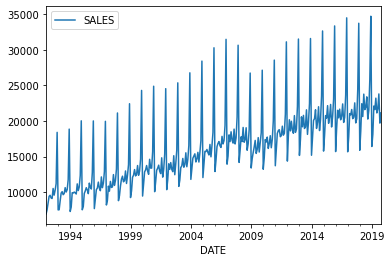

In [5]:
df.plot()

In [6]:
len(df)

334

In [7]:
#choose a little more than a year for length:
test_index=len(df)-18

In [8]:
test_index

316

In [9]:
train=df.iloc[:test_index]
test=df.iloc[test_index:]

In [10]:
train

,SALES
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [11]:
scaler=MinMaxScaler()

In [13]:
train_scaled=scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [14]:
train_scaled

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747],
       [0.11163956],
       [0.12372931],
       [0.17506535],
       [0.43250799],
       [0.0124165 ],
       [0.03499855],
       [0.10829945],
       [0.10641156],
       [0.11149434],
       [0.10728289],
       [0.10154662],
       [0.1531731 ],
       [0.11904589],
       [0.13767064],
       [0.19663085],
       [0.47480395],
       [0.02105722],
       [0.03714058],
       [0.10445106],
       [0.11726692],
       [0.13367703],
       [0.12209556],
       [0.10332559],
       [0.1570578 ],
       [0.13694453],
       [0.12710572],
       [0.21104415],
       [0.474

In [15]:
length=12
generator=TimeseriesGenerator(train_scaled,train_scaled,length=length,batch_size=1)

In [16]:
valid_generator=TimeseriesGenerator(test_scaled,test_scaled,length=length,batch_size=1)

In [17]:
X,Y=generator[0]

In [18]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [19]:
Y

array([[0.02047633]])

In [20]:
n_features=1
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(12,n_features))) # you can also play around with the activation/dropout , ...
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [23]:
model.fit_generator(generator,epochs=20,validation_data=valid_generator,callbacks=[early_stop])

Epoch 1/20


<ipython-input-23-911f88337e0e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=valid_generator,callbacks=[early_stop])


304/304 [==============================] - 2s 4ms/step - loss: 0.0253 - val_loss: 0.0115
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0058
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0333
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0117
Epoch 7/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0020


In [24]:
losses=pd.DataFrame(model.history.history)

<AxesSubplot:>

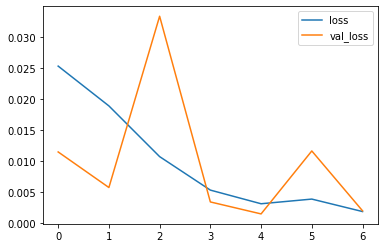

In [25]:
losses.plot()

In [26]:
tes_predictions=[]

first_eval_batch=train_scaled[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    
    current_pred=model.predict(current_batch)[0] #to return just the elelemnt and not 2ble [[]]
    
    tes_predictions.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 18ms/step


In [27]:
True_predictions=scaler.inverse_transform(tes_predictions)
test['Predictions']=True_predictions

<ipython-input-27-798e03ef6d5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=True_predictions


<AxesSubplot:xlabel='DATE'>

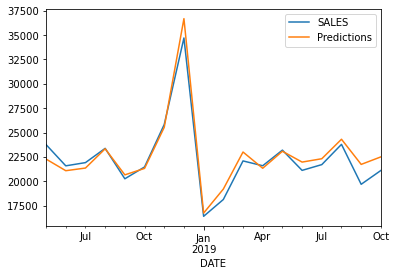

In [32]:
 test.plot() # the general seasonality is detected.

# Forcast

In [30]:
full_scaler=MinMaxScaler()
full_data_scaled=full_scaler.fit_transform(df)

In [ ]:
geenrator=TimeseriesGenerator(df,df,length=length,batch_size=1)

In [ ]:
n_features=1
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(12,n_features))) # you can also play around with the activation/dropout , ...
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8) #cheating based on predcition, 8 epochs seem good

In [37]:
forcast=[]
periods= 12
first_eval_batch=train_scaled[-length:]
current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(periods):
    
    current_pred=model.predict(current_batch)[0] #to return just the elelemnt and not 2ble [[]]
    
    forcast.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 17ms/step


In [58]:
train_scaled[-length:]

array([[0.53252977],
       [0.48591345],
       [0.49364653],
       [0.56629393],
       [0.46405751],
       [0.48536886],
       [0.63534708],
       [0.97233517],
       [0.32468051],
       [0.42285071],
       [0.5615016 ],
       [0.49658728]])

-12

In [38]:
forcast=scaler.inverse_transform(forcast)


In [39]:
forcast

array([[22281.42431831],
       [21089.26074505],
       [21362.01950407],
       [23339.28286362],
       [20662.89572024],
       [21324.80594921],
       [25541.933918  ],
       [36688.07902908],
       [16743.95804405],
       [19204.7653091 ],
       [23005.59546614],
       [21339.98228931]])

In [40]:
df

,SALES
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
#Pandas fequency code search on goodle
forcast_index=pd.date_range(start='2019-11-01',periods=periods,freq='MS')

NameError: name 'pd' is not defined

In [42]:
forcast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [43]:
forcast_df=pd.DataFrame(data=forcast,index=forcast_index
                       , columns=['Forcast'])

In [44]:
forcast_df

,Forcast
2019-11-01,22281.424318
2019-12-01,21089.260745
2020-01-01,21362.019504
2020-02-01,23339.282864
2020-03-01,20662.895720
2020-04-01,21324.805949
2020-05-01,25541.933918
2020-06-01,36688.079029
2020-07-01,16743.958044
2020-08-01,19204.765309


<AxesSubplot:>

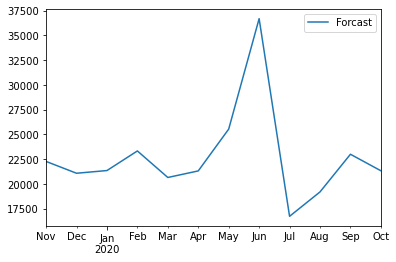

In [45]:
forcast_df.plot()

<AxesSubplot:xlabel='DATE'>

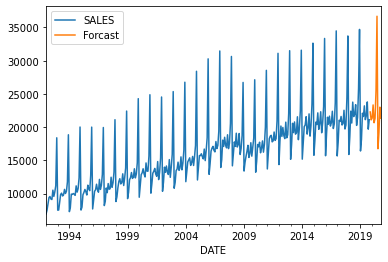

In [46]:
ax=df.plot()
forcast_df.plot(ax=ax)


In [1]:
ax=df.plot()
forcast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

NameError: name 'df' is not defined

In [53]:
model.save('foodsale_model.h5')

In [10]:
import joblib

In [55]:
joblib.dump(scaler,'sale_scaler.pkl')

['sale_scaler.pkl']

In [62]:
np.savetxt('first_eval_batch.txt', train_scaled[-length:])


In [8]:
from tensorflow.keras.models import load_model

In [15]:
sale_model=load_model('foodsale_model.h5')
sale_scaler=joblib.load('sale_scaler.pkl')
f_eval_batch=np.loadtxt('first_eval_batch.txt')
df=pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [16]:
import io

def sale_forcast(model,scaler,f_eval_batch,period):
    forcast=[]
    periods= period
    n_features=1
    length=12
    first_eval_batch=f_eval_batch
    current_batch=first_eval_batch.reshape(1,length,n_features)

    for i in range(periods):
    
        current_pred=model.predict(current_batch)[0] #to return just the elelemnt and not 2ble [[]]
    
        forcast.append(current_pred)
    
        current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    forcast=scaler.inverse_transform(forcast)
    forcast_index=pd.date_range(start='2019-11-01',periods=periods,freq='MS')
    forcast_df=pd.DataFrame(data=forcast,index=forcast_index
                       , columns=['Forcast'])
    ax=df.plot()
    forcast_df.plot(ax=ax)
    bytes_image = io.BytesIO()
    plt.savefig("") 
    plt.savefig(bytes_image, format='png')
    bytes_image.seek(0)
    return bytes_image
    

1/1 [==============================] - 0s 17ms/step


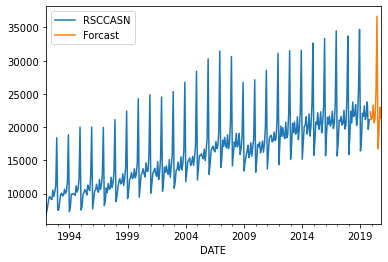

In [17]:
sale_forcast(sale_model,sale_scaler,f_eval_batch,period=12)

(576.0, 611.0)

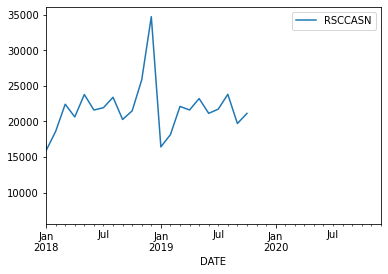

In [19]:
ax=df.plot()
plt.xlim('2018-01-01','2020-12-01')

In [10]:
df.columns

Index(['SALES'], dtype='object')